# Window Washing Company: Data Analysis

This notebook was built to identify which clients were most likely to upgrade to subscription packages with a window cleaning company in Chicago.

The outline for this notebook is as follows:
> I. [Loading Data](#section-1) <br /> 
> II. [Preliminary Analysis](#section-2) <br /> 
> III. [Modeling](#section-3) <br /> 
> IV. [Conclusion](#section-4) <br /> 

<a id='section-1'></a>
## I. Loading Data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.max_columns', None)

In [2]:
# Path for datasets
path = 'Datasets_09.06.2019/'

# Loading data and removing extra rows
invoices = pd.read_csv(path+'Invoices Report.csv', 
                          skiprows=13, 
                          skipfooter=1, 
                          engine='python')
one_off = pd.read_csv(path+'One off Jobs Report.csv', 
                          skiprows=11, 
                          skipfooter=1, 
                          engine='python')
payments = pd.read_csv(path+'Jobber Payments Transaction List.csv', 
                          skiprows=0, 
                          skipfooter=1, 
                          engine='python')
properties = pd.read_csv(path+'Client Properties.csv', 
                          skiprows=0, 
                          skipfooter=1, 
                          engine='python')
recurring = pd.read_csv(path+'Recurring Jobs Report.csv', 
                          skiprows=9, 
                          skipfooter=1, 
                          engine='python')
services = pd.read_csv(path+'Products and Services Report.csv', 
                          skiprows=0, 
                          skipfooter=1, 
                          engine='python')
timesheets = pd.read_csv(path+'Timesheets Report.csv', 
                          skiprows=14, 
                          skipfooter=1, 
                          engine='python')
transactions = pd.read_csv(path+'Transaction List.csv', 
                          skiprows=10, 
                          skipfooter=1, 
                          engine='python')
visits = pd.read_csv(path+'Visits Report.csv', 
                          skiprows=0, 
                          skipfooter=1, 
                          engine='python')

Notes on the datasets:
1. **invoices**: *detailed account of all invoices*. Relevant features include: client, date, employee assigned to, cost of service, subscription package.
2. **one_off**: *record of one-off services*.
3. **payments**: *record of client payments*
4. **properties**: *detailed account of client addresses*
5. **recurring**: *record of recurring services*
6. **services**: *record of which services brought in the most revenue*
7. **timesheets**: *record of how much time employee spends on assignment*
8. **transactions**: *account of client payments*
9. **visits**: *most detailed dataset which contains client, location, employee, cleaning type, and cost*

In [3]:
def snapshot(data):
    '''Creates df with snapshot of original df for cleaning and analysis.'''
    preliminary_details = pd.DataFrame()
    preliminary_details['Type'] = data.dtypes
    preliminary_details['Unique'] = data.nunique()
    preliminary_details['NaN'] = data.isnull().sum()
    preliminary_details['NaN_%'] = (data.isnull().sum() / len(data)) * 100
    return preliminary_details

<a id='section-2'></a>
## II. Preliminary Analysis

### A. Services
Identifying:
1. which services have brought in greatest revenue collectively 
2. which individual services bring in greatest revenue.

In [4]:
# Converting objects to float values
services['Invoiced $'] = services['Invoiced $'].str.replace(',','').astype(float)
services['Quoted $'] = services['Quoted $'].str.replace(',','').astype(float)
services['Jobs $'] = services['Jobs $'].str.replace(',','').astype(float)

In [5]:
# Previewing characteristics of df
snapshot(services)

,Type,Unique,NaN,NaN_%
Name,object,84,0,0.0
Quoted qty,int64,12,0,0.0
Quoted $,float64,38,0,0.0
Jobs qty,int64,25,0,0.0
Jobs $,float64,52,0,0.0
Invoiced qty,int64,32,0,0.0
Invoiced $,float64,61,0,0.0


In [6]:
# Identifying services that yield greatest revenue
services.sort_values(by='Jobs $', ascending=False).head(10)

,Name,Quoted qty,Quoted $,Jobs qty,Jobs $,Invoiced qty,Invoiced $
0,Anti-graffiti Window Film Installation,62,33583.0,20,16751.50,19,16472.75
7,CLEAN Subscription,12,313.0,182,6941.50,1553,56766.00
79,VERY CLEAN Subscription,19,655.0,212,5973.74,3685,91503.22
55,PLUS Subscription,2,46.0,155,3926.75,1506,29515.29
13,CUSTOM Subscription,1,148.0,51,3881.00,453,25583.25
33,Exterior Window Cleaning,14,1703.0,58,3626.50,298,12704.50
52,On Demand Window Cleaning,2,160.0,12,3585.00,9,3185.00
5,CLEAN+,3,122.0,83,3288.60,527,18353.20
78,VERY CLEAN++,1,140.0,65,2899.50,887,27782.50
47,Interior Window Cleaning,10,698.0,71,2623.64,124,5312.50


In [7]:
# Identifying services that yield greatest revenue
services.sort_values(by='Quoted $', ascending=False).head(10)

,Name,Quoted qty,Quoted $,Jobs qty,Jobs $,Invoiced qty,Invoiced $
0,Anti-graffiti Window Film Installation,62,33583.0,20,16751.50,19,16472.75
56,Privacy Window Film,1,4159.0,0,0.00,0,0.00
33,Exterior Window Cleaning,14,1703.0,58,3626.50,298,12704.50
30,Exterior/Interior Window Cleaning,1,1500.0,10,2381.00,17,3147.00
82,Window Film Removal,23,1444.0,13,727.00,21,1103.00
43,Graffiti Removal,1,1200.0,0,0.00,0,0.00
65,Security Window Film Installation,5,1146.0,3,441.00,3,441.00
67,Solar Window Film Installation,5,840.0,12,420.00,6,1107.00
47,Interior Window Cleaning,10,698.0,71,2623.64,124,5312.50
79,VERY CLEAN Subscription,19,655.0,212,5973.74,3685,91503.22


### B. Timesheets
Identifying:
1. Efficiency in workers

In [8]:
# Removing rows not associated with recorded job (i.e. general, commute, etc.)
bool_jobs = ['Job' in record for record in timesheets['Working on']]
only_jobs = timesheets[bool_jobs]

In [9]:
# Grouping by date and employee
counts_per_day = only_jobs.groupby(['Date', 'Name']).count()

# Calculating days worked and daily jobs completed per employee
days_worked = counts_per_day.groupby('Name')['Start time'].count()
jobs_completed = counts_per_day.groupby('Name')['Working on'].sum()

# Initializing DataFrame
per_employee = pd.DataFrame({'days_worked': days_worked})
per_employee['jobs_completed'] = jobs_completed
per_employee['jobs_per_day'] = jobs_completed / days_worked

# Previewing (hiding index for anonymity)
per_employee.style.hide_index()

days_worked,jobs_completed,jobs_per_day
26,208,8
9,63,7
234,3072,13.1282
62,867,13.9839
46,338,7.34783
16,93,5.8125
25,181,7.24
66,534,8.09091
46,296,6.43478
74,818,11.0541


### C. Properties
Using [Geocodio](https://www.geocod.io), we are able to extract latitude and longitude from the created concatenated properties file in the folder. This is appended to the properties dataframe.

Identifying:
1. Geolocation of client properties

In [10]:
geo_loc = pd.read_csv(path+'concat_locations_geocodio.csv', 
                          skiprows=0, 
                          skipfooter=0,
                          engine='python')

In [11]:
properties_geo = pd.concat([properties, geo_loc[['Latitude','Longitude','Accuracy Score']]], axis=1, sort=False)

In [12]:
# ['Resolt','Brandnetizen'] in properties_geo
foo = [name not in ['Resolt','Brandnetizen','Company Name'] for name in properties_geo.Name]
properties_geo = properties_geo[foo]

In [13]:
# Loading shapefile of Chicago
file = 'geo_export_9b5fc045-421f-4420-855e-1ce5074ac72b.shp'
chicago_map = gpd.read_file(file)

In [14]:
# Creating GeoPanda specific feature with geo-data
geometry = [Point(xy) 
            for xy 
            in zip(properties_geo.Longitude, properties_geo.Latitude)
           ]

# Specifying GeoPanda CRS (tells Python how coordinates relate to Earth)
crs = {'init':'epsg:4326'}

# Populating GeoPanda df
geo_df = gpd.GeoDataFrame(properties_geo, #specify data
                         crs = crs, # specify coordinate reference system
                         geometry = geometry #specify geometry list
                         ) 

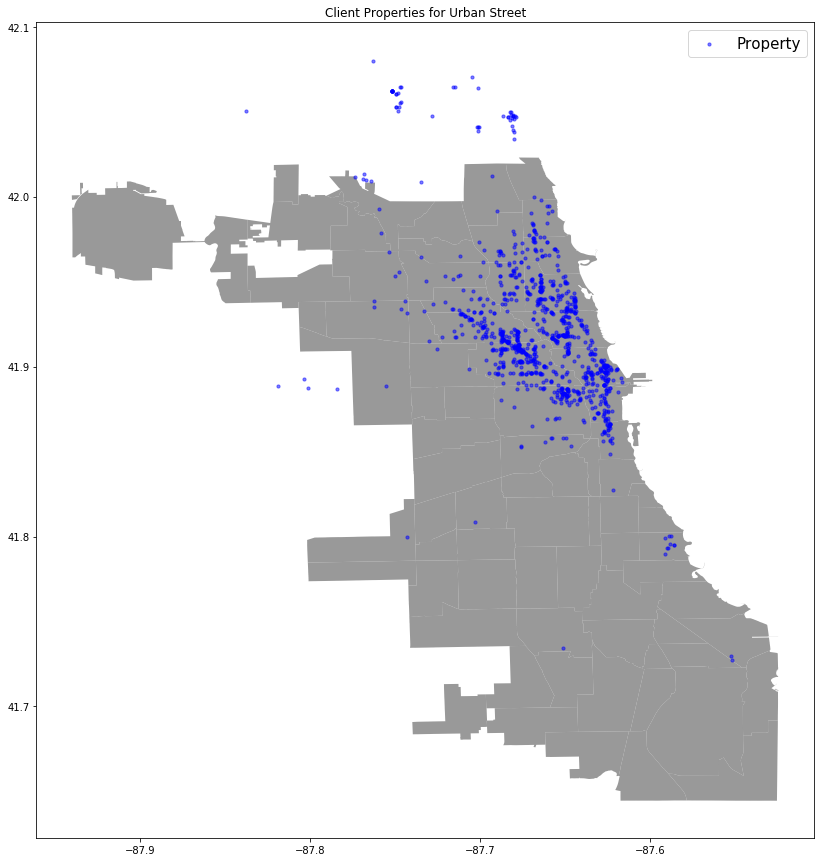

In [15]:
# Plotting map
fig, ax = plt.subplots(figsize=(15,15))
chicago_map.plot(ax=ax, alpha=0.8, color='grey')

# Plotting arrests and non-arrests on map
geo_df.plot(ax=ax, 
            markersize=10, 
            color='blue', 
            marker='o', 
            alpha=.5, 
            label='Property'
           )

plt.legend(prop={'size':15})
plt.title('Client Properties for Urban Street')
plt.show()

### 4. Invoices

Identifying:
1. Greatest revenue sources

In [16]:
invoices['Total $'] = invoices['Total $'].replace('[\$,]', '', regex=True).astype(float)
invoices['Balance $'] = invoices['Balance $'].replace('[\$,]', '', regex=True).astype(float)

In [17]:
foo = invoices.groupby('Subscription Package')['Total $'].agg(['mean','count'])
foo.sort_values('mean', ascending=False)

,mean,count
Subscription Package,,
- Select -,105.647173,711
QUARTERLY CLEAN +,83.846154,26
SUPER CLEAN ++++,59.192599,685
VERY CLEAN ++,48.789133,888
CLEAN +,48.641197,568
QUARTERLY CLEAN,46.000000,8
VERY CLEAN +,45.687348,1678
CLEAN,39.230545,1339
SUPER CLEAN +,38.191940,1557


### 5. Payments
Identifying:
1. Highest revenue-generating clients

In [18]:
payments['Total $'] = payments['Total $'].str.replace(',','').astype(float)

In [19]:
# Identifying biggest clients
clients = payments.groupby('Client name').sum()

# Previewing (Hiding index for anonymity)
clients.sort_values(by='Total $').head(10).style.hide_index()

Total $,Fee $,Card ending #,Invoice #,Quote #
-9356,272.53,20440,38328,0
-4310,133.09,73548,144373,0
-3246,100.76,77413,98989,0
-3080,93.52,12768,56666,0
-3036,97,140580,171108,0
-3020,91.78,22946,78013,0
-2560,81.74,92175,132620,0
-2423,78.73,28028,170978,0
-2340,77.59,111744,161655,0
-2189.6,73.64,29274,186567,0


### 6. Visits

Identifying:
1. How many clients upgraded to subscription?
2. How many clients have yet to upgrade to subscription?

In [20]:
# Changing dtypes
visits['Date'] = pd.to_datetime(visits['Date'])
visits['One-off job $'] = visits['One-off job $'].str.replace(',','').astype(float)
visits['City'] = visits['City'].str.capitalize()

In [21]:
# Separating visits into subscription or non-subscription
subscription_visits = visits[visits['Line items'].str.contains('Subscription').replace(np.nan, False)]
nonsubscription_visits = visits[~visits['Line items'].str.contains('Subscription').replace(np.nan, False)]

# Grouping subscription visits by client (some clients have same name but different addresses)
subscription_clients = subscription_visits.groupby(['Client name','Address'])\
    .sum().sort_values(by='Visit based $', ascending=False)

# Grouping non-subscription visits by client
nonsubscription_clients = nonsubscription_visits.groupby(['Client name','Address'])\
    .sum().sort_values(by='Visit based $', ascending=False)
# Removing non-subscription clients who never made a payments
nonsubscription_clients = nonsubscription_clients[nonsubscription_clients['Visit based $'] > 0]

In [22]:
print('Using visits records, there exist {} clients.'\
      .format(len(visits.groupby(['Client name','Address']))))
print('Using visits records, {} clients are/were subscription clients.'\
      .format(subscription_clients.shape[0]))
print('Using visits records, {} clients never have been subscription clients.'\
      .format(nonsubscription_clients.shape[0]))

Using visits records, there exist 715 clients.
Using visits records, 491 clients are/were subscription clients.
Using visits records, 219 clients never have been subscription clients.


In [23]:
# Purifying nonsub client list by removing upgrades
unconverted = []
for target in nonsubscription_clients.index:
    if target not in subscription_clients.index:
        unconverted.append(target)

# Creating converted sub client list by recording overlap
converted = []
for target in nonsubscription_clients.index:
    if target in subscription_clients.index:
        converted.append(target)

print('Out of {} clients who began without subscription, {} have converted!' \
      .format(len(nonsubscription_clients.index), len(converted)))
print('Out of {} clients who began without subscription, {} have yet to be converted.' \
      .format(len(nonsubscription_clients.index), len(unconverted)))

Out of 219 clients who began without subscription, 55 have converted!
Out of 219 clients who began without subscription, 164 have yet to be converted.


<a id='section-3'></a>
## III. Modeling
### A. Feature Engineering

In [24]:
# Grouping by client and extracting City and ZIP Code
to_extract = nonsubscription_visits.groupby(['Client name','Address']).first()

In [25]:
# Creating target feature
subscribed = []
for entry in nonsubscription_clients.index:
    if entry in converted:
        subscribed.append(True)
    else:
        subscribed.append(False)
        
# Creating df and adding target feature
model_df = nonsubscription_clients
model_df.rename(columns={'Duration':'sum_duration', 'Visit based $':'visit_sum',
                        'One-off job $':'one_off_sum','City':'city','ZIP code':'zip'},
               inplace=True)

# Changing 0 value to median value for sum duration of visits
model_df['sum_duration'].replace(0, model_df.sum_duration.median(), inplace=True)

# Adding features
model_df['total_sum'] = model_df.one_off_sum + model_df.visit_sum
model_df['total_div_time'] = model_df['total_sum'] / model_df['sum_duration']
model_df = model_df.merge(to_extract[['City','ZIP code']], 
                          left_index=True, right_index=True)
model_df.rename(columns={'City':'city','ZIP code':'zip'}, inplace=True)
model_df['converted'] = subscribed

In [26]:
# Creating feature dataframe: most frequent clean style
add_features = pd.DataFrame(nonsubscription_visits.groupby\
        (['Client name','Address'])['Line items'].agg(pd.Series.mode))\
        .rename(columns={"Line items": "frequent_clean"})

In [27]:
# Adding other features
add_features['number_visits'] = nonsubscription_visits.groupby\
        (['Client name','Address'])['Date'].count()
add_features['main_cleaner'] = nonsubscription_visits.groupby\
        (['Client name','Address'])['Assigned to'].agg(pd.Series.mode)
add_features['first_clean'] = nonsubscription_visits.groupby\
        (['Client name','Address'])['Date'].first()
add_features['last_clean'] = nonsubscription_visits.groupby\
        (['Client name','Address'])['Date'].last()
add_features['time_span'] = (add_features['last_clean'] - \
        add_features['first_clean']).dt.days

In [28]:
# Creating feature to calculate average days between visit
dates_data = nonsubscription_visits[['Date','Client name','Address']].copy()
dates_data['previous_visit'] = dates_data.groupby(['Client name', 'Address'])['Date'].shift()
dates_data['days_bw_visits'] = dates_data['Date'] - dates_data['previous_visit']
dates_data['days_bw_visits'] = dates_data['days_bw_visits'].apply(lambda x: x.days)
days_bw = dates_data.groupby(['Client name', 'Address'])['days_bw_visits'].agg('mean')

# Adding to feature dataframe
add_features['days_bw_visits'] = days_bw

# Filling NaN values for properties who only had one visit
add_features['days_bw_visits'].fillna(0, inplace=True)

In [29]:
# Merging features to original model df
model_df = model_df.merge(add_features, 
                          left_index=True, right_index=True)

In [30]:
# Adding feature: average total cost per visit
model_df['mean_cost_per_vis'] = model_df['total_sum']/model_df['number_visits']

In [31]:
# Changing column type with unhashable list to string
model_df['main_cleaner'] = model_df['main_cleaner'].astype(str)
model_df['frequent_clean'] = model_df['frequent_clean'].astype(str)

### B. Clustering

In [32]:
# Creating dummy variables of categorical
model_df_dummies = pd.get_dummies(model_df)

# Removing timestamp features for clustering/modeling
model_df_dummies.drop(['first_clean','last_clean'], 1, inplace=True)

In [33]:
model_df_dummies.shape

(219, 107)

In [34]:
# Define the features and the outcome.
X = model_df_dummies.drop('converted', axis=1)
y = model_df_dummies['converted']

# Binarize y so that 1 means unconverted and 0 means converted
y = np.where(y > 0, 0, 1)

In [35]:
# Normalizing
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

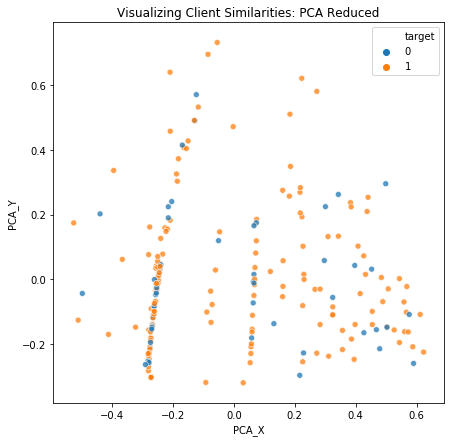

In [36]:
# Creating df for plotting
PCA_df = pd.DataFrame(X_pca, columns=['PCA_X','PCA_Y'])
PCA_df['target'] = y

plt.figure(figsize=[7,7])
ax = sns.scatterplot(x="PCA_X", y="PCA_Y", hue="target", alpha=.75, data=PCA_df)
plt.title('Visualizing Client Similarities: PCA Reduced')
plt.show()

With PCA Reduction, we see a potential cluster/line of similar clients in the bottom left that seems to represent a majority of subscription clients with a few non-subscription clients in the mix. This could lead to a few promising subscription clients! This observation seems to be confirmed by KMeans Clustering in its desire to cluster the left overall to subscription and the right overall as non-subscription.

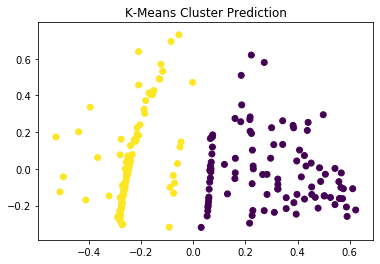

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      23  76
1      32  88


In [37]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.title('K-Means Cluster Prediction')
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

### C. Cosine Similarity Recommendations
#### i. Full Feature Set

In [38]:
# Comparing similarities of specific unconverted clients to converted clients as a whole 
unconverted_dummies = (model_df_dummies[model_df_dummies['converted'] == False]).drop('converted', 1)
converted_dummies = (model_df_dummies[model_df_dummies['converted'] == True]).drop('converted', 1)

In [39]:
# Implementing model
cosine = cosine_similarity(converted_dummies, unconverted_dummies, dense_output=True)
# Transposing
cosine_trans = cosine.T

# Grouping cosines with client names
ix = list(unconverted_dummies.index)
l = []
for elem, index in zip(cosine_trans, ix):
    l.append([index, elem.mean()])

In [40]:
# Previewing
client_similarities = pd.DataFrame(l)
client_similarities = client_similarities.sort_values\
    (by=1, ascending=False).reset_index(drop=True)
client_similarities[client_similarities[1] > .90]

,0,1
0,"(Jimmy John's 0303, 1101 South Canal Street)",0.921984
1,"(Blue Bird Day School - North Center, 1921 W I...",0.921563
2,"(Jimmy John's 0570, 725 South State Street)",0.921046
3,"(Peppercorns Kitchen, 620 Davis Street)",0.918899
4,"(Publican Quality Bread, 808 West Lake Street)",0.918328
5,"(Bang Bang Pie, 2051 N California Ave)",0.917982
6,"(Crossroads Trading Co. - Wicker Park, 1519 No...",0.917887
7,"(Read It & Eat, 2142 North Halsted Street)",0.917083
8,"(Goldfish Swim School - Evanston, 2008 Dempste...",0.917030
9,"(Crossroads Trading Co. - Evanston, 1730 Sherm...",0.916381


#### ii. Reduced Feature Set
This new feature set will be used to verify the similarities above by removing potentially insidious features that might not have an affect (or hinder prediction) on the end result (due to their sparsity); these features are `main_cleaner` and `frequent_clean`.

In [41]:
# Creating reduced feature DF
qa_1 = model_df.drop(['first_clean','last_clean','main_cleaner','frequent_clean'], 1)
qa_1 = pd.get_dummies(qa_1)

# Separating converted/unconverted clients for comparison
unconverted_qa_1 = (qa_1[qa_1['converted'] == False]).drop('converted', 1)
converted_qa_1 = (qa_1[qa_1['converted'] == True]).drop('converted', 1)

In [42]:
# Implementing model
cosine_2 = cosine_similarity(converted_qa_1, unconverted_qa_1, dense_output=True)
cosine_trans_2 = cosine_2.T

# Grouping cosines with client names
ix_2 = list(unconverted_qa_1.index)
l_2 = []
for elem, index in zip(cosine_trans_2, ix_2):
    l_2.append([index, elem.mean()])

In [43]:
# Previewing and verifing
qa_1_client_similarities = pd.DataFrame(l_2)
qa_1_client_similarities = qa_1_client_similarities.sort_values\
    (by=1, ascending=False).reset_index(drop=True)
qa_1_client_similarities[qa_1_client_similarities[1] > .90]

,0,1
0,"(Jimmy John's 0303, 1101 South Canal Street)",0.922007
1,"(Blue Bird Day School - North Center, 1921 W I...",0.921593
2,"(Jimmy John's 0570, 725 South State Street)",0.921067
3,"(Peppercorns Kitchen, 620 Davis Street)",0.918921
4,"(Publican Quality Bread, 808 West Lake Street)",0.918350
5,"(Bang Bang Pie, 2051 N California Ave)",0.918004
6,"(Crossroads Trading Co. - Wicker Park, 1519 No...",0.917909
7,"(Read It & Eat, 2142 North Halsted Street)",0.917106
8,"(Goldfish Swim School - Evanston, 2008 Dempste...",0.917051
9,"(Crossroads Trading Co. - Evanston, 1730 Sherm...",0.916403


The top 10 clients in both cosine similarities are the same, giving confidence to our initial prediction that used the full feature set.

<a id='section-4'></a>
## IV. Conclusion

The list below contains the 20 clients most likely to upsell to subscription clients based on the features used. The reason for identifying these potential subscription clients is that subscriptions provide predictable transactions, more frequent visits (consequently, with higher revenue), and even greater visibility.

In [44]:
list(client_similarities[client_similarities[1] > .9][0])

[("Jimmy John's 0303", '1101 South Canal Street'),
 ('Blue Bird Day School - North Center', '1921 W Irving Park Rd'),
 ("Jimmy John's 0570", '725 South State Street'),
 ('Peppercorns Kitchen', '620 Davis Street'),
 ('Publican Quality Bread', '808 West Lake Street'),
 ('Bang Bang Pie', '2051 N California Ave'),
 ('Crossroads Trading Co. - Wicker Park', '1519 North Milwaukee Avenue'),
 ('Read It & Eat', '2142 North Halsted Street'),
 ('Goldfish Swim School - Evanston', '2008 Dempster Street'),
 ('Crossroads Trading Co. - Evanston', '1730 Sherman Avenue'),
 ("Kuma's Corner", '2900 W Belmont Ave.'),
 ('Rosin Eyecare - Andersonville', '5605 North Clark Street'),
 ('The Publican', '837 West Fulton Market'),
 ('Best Care Cleaners', '1623 Chicago Avenue'),
 ('Empanadas 5411 - North', '2045 West North Avenue'),
 ('Zea Salon', '3707 N Halsted St, Chicago'),
 ('Genacelli Salon', '999.5 West Wilson'),
 ('Publican Quality Meats', '825 West Fulton Market'),
 ('Jeong', '1460 W. Chicago Ave'),
 ('Tabu

In [45]:
unconv_sum = unconverted_dummies['total_sum'].median()
conv_sum = converted_dummies['total_sum'].median()
print('Median cost of unconverted client visit: {}'.format(unconv_sum))
print('Median cost of converted client visit: {}'.format(conv_sum))

Median cost of unconverted client visit: 371.5
Median cost of converted client visit: 350.0


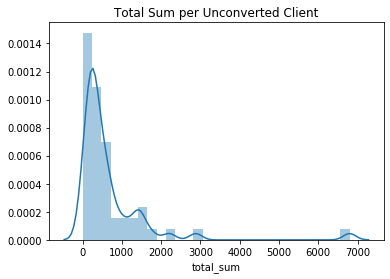

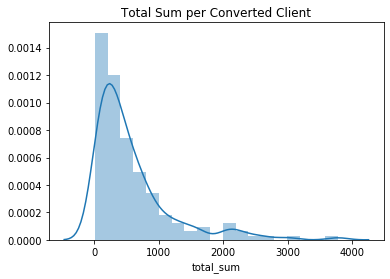

In [46]:
# Viewing distributions
sns.distplot(converted_dummies['total_sum'])
plt.title('Total Sum per Unconverted Client')
plt.show()
sns.distplot(unconverted_dummies['total_sum'])
plt.title('Total Sum per Converted Client')
plt.show()

In [47]:
unconv_days = unconverted_dummies['days_bw_visits'].median()
conv_days = converted_dummies['days_bw_visits'].median()
print('Median days between visits for unconverted client: {}'.format(unconv_days))
print('Median days between visits for converted client: {}'.format(conv_days))

Median days between visits for unconverted client: 15.873188405797102
Median days between visits for converted client: 16.375


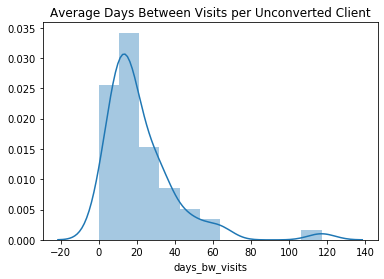

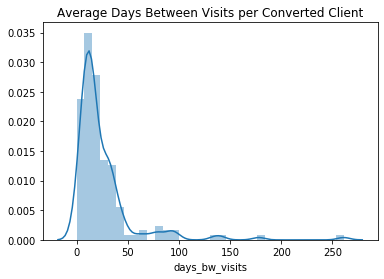

In [48]:
# Viewing distributions
sns.distplot(converted_dummies['days_bw_visits'])
plt.title('Average Days Between Visits per Unconverted Client')
plt.show()
sns.distplot(unconverted_dummies['days_bw_visits'])
plt.title('Average Days Between Visits per Converted Client')
plt.show()

## Addendum

In [49]:
# Full client preview list in order of cosine similarity (removed for anonymity)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(client_similarities)